### BZAN 6357 Frameworks and Methods
# Final Project

**Students**:
* Dan Li - 1645025
* Melany Jimenez - 0963243

<a id=Index><a/>
# Table of Contents  <font color='red'></font>
- [Introduction](#Introduction)
- [Project Objective](#Project_Objective)
- [Data Preparation](#Data_preparation)
- [Exploratory Data Analysis](#EDA)
- [Model Development and Evaluation](#Model_development)
  - [Option 1: 10 epochs](#10_epochs)
    1. Basic MLP, SGD
    1. MLP with L2 regularization, Adam
    1. MLP with L2 regularization, Adam, 10% train set allotted to validation set
    1. MLP with L2 regularization, Adam, 10% validation, improved activation functions
  - [Option 2: 300 epochs](#10_epochs)
    1. Basic MLP, SGD
    1. MLP with L2 regularization, Adam
    1. MLP with L2 regularization, Adam, 10% train set allotted to validation set
    1. MLP with L2 regularization, Adam, 10% validation, improved activation functions
  - [Option 3: 10 epochs, 6 neurons](#10_neurons)
    1. Basic MLP, SGD
    1. MLP with L2 regularization, Adam
    1. MLP with L2 regularization, Adam, 10% train set allotted to validation set
    1. MLP with L2 regularization, Adam, 10% validation, improved activation functions
  - [Option 4: 10 epochs, 6 neurons, updating Weight](#weight)
    1. Basic MLP, SGD
    1. MLP with L2 regularization, Adam
    1. MLP with L2 regularization, Adam, 10% train set allotted to validation set
    1. MLP with L2 regularization, Adam, 10% validation, improved activation functions
  - [Option 5: 10 epochs, 6 neurons, updating batch size](#batch)
    1. Basic MLP, SGD
    1. MLP with L2 regularization, Adam
    1. MLP with L2 regularization, Adam, 10% train set allotted to validation set
    1. MLP with L2 regularization, Adam, 10% validation, improved activation functions
  - [Models Analysis](#analysis)
- [Predict](#Predict)
- [Summary](#Summary)

<a id='Introduction'></a>
# Introduction

An insurance company attemps to sell car insurance to its current medical insurance policyhoders who are believed to be vehicles owners. The company want to persuade customers who will have a new vehicles and customers who may want to switch insurance company from others by providing discount applied to the multi-policy annual premium. 

<a id='Project_Objective'></a>
# Project Objective

In order to predict customers who buy or not buy the car insurance, we will use supervised algorithms (multilayer perceptron) to help company to make a decision for which customer will change their car insurance company. In our process, we will go through data preparation phase, modeling phase, evaluation phase, and development phase. 

<a id='Data_preparation'></a>
## <font color='blue'>1.- Data Preparation </font>

<a id='symbols'></a>
## Import packages

In [2]:
import numpy as np
import pandas as pd
from numpy import NaN as NA
import numpy.random as random
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.weightstats import ttest_ind
from sklearn.utils import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, roc_curve, precision_score, f1_score
from time import time

%matplotlib inline
sns.set_style('ticks')


In [3]:
np.random.seed(30)
random_state = 30

## Open Source packages for ANN and MLP

In [4]:
import tensorflow as tf
# print(tf.__version__)

In [5]:
from tensorflow import keras
# print(keras.__version__)

In [6]:
# this is so that results are replicable
# DO NOT CHANGE THIS!!
tf.random.set_seed(random_state)

## Read data

In [7]:
insur_t = pd.read_csv('bzan6357_insurance_3_TRAINING.csv')
insur_s =pd.read_csv('bzan6357_insurance_3_SCORE.csv')

### *verify there is no missing value in both sets*

In [8]:
print('there is {} missing value(s) in the train set'.format(insur_t.isna().sum().sum()))
print('~' * 50)
print('there is {} missing value(s) in the test set'.format(insur_s.isna().sum().sum()))

there is 0 missing value(s) in the train set
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
there is 0 missing value(s) in the test set


In [9]:
insur_t.dtypes

id_new              object
buy                  int64
age                  int64
gender              object
tenure               int64
region               int64
dl                   int64
has_v_insurance      int64
v_age               object
v_accident          object
v_prem_quote       float64
cs_rep               int64
dtype: object

# Preprocess data

In [10]:
X = insur_t.drop(columns=['id_new','buy'])
y = insur_t['buy'].copy()


In [11]:
# Performing the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state, shuffle=True)

### *Evaluate validity of split using hypothesis-testing*

#### Null hypothesis: The proportion of customers who buy insurance is the same in the train and test sets.

In [12]:
count_default_train = y_train.value_counts()[1]
count_default_test = y_test.value_counts()[1]
z_stat, p = proportions_ztest(count=[count_default_train, count_default_test], nobs=[y_train.shape[0], y_test.shape[0]])
print('z-stat = {:0.3f}, p = {:0.3f}'.format(z_stat, p))

z-stat = 0.369, p = 0.712


**Analysis**:


We assume alpha =0.05.  z_stat=0.369, p=0.712
Becasue p > α which is 0.05, conclude that H0 is not rejected
Conclusion: The proportion of customers who buy insurance is the same in the train and test sets.

<a id='EDA'></a>
## <font color='blue'>2.- Exploratory Data Analysis </font>



Text(0.5, 0, 'regions')

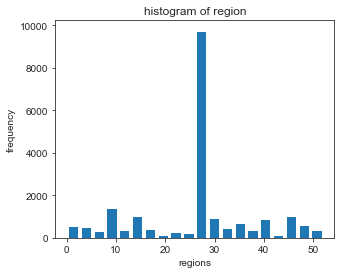

In [13]:
fig, ax=plt.subplots(1,1,figsize=(5,4))
plt.hist(insur_t.region,bins=20,rwidth=0.8)
plt.title('histogram of region')
plt.ylabel('frequency')
plt.xlabel('regions')

***Analysis***

Region represent the area, We will put this variable into one-hot-encoder function. 

Text(0.5, 0, 'cs_rep')

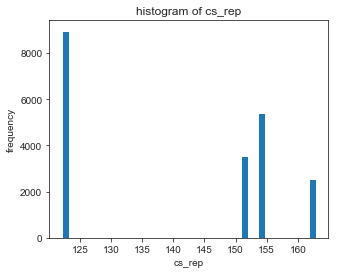

In [11]:
fig, ax=plt.subplots(1,1,figsize=(5,4))
plt.hist(insur_t.cs_rep,bins=30,rwidth=0.8)
plt.title('histogram of cs_rep')
plt.ylabel('frequency')
plt.xlabel('cs_rep')

In [12]:
n_labels=insur_t['cs_rep'].nunique()
labels=np.sort(insur_t['cs_rep'].unique())
print(f'there are {n_labels} discrete labes in "cs_rep";they are: {labels}')
print(f'thus,{n_labels - 1} flag vars are needed')

there are 4 discrete labes in "cs_rep";they are: [122 151 154 163]
thus,3 flag vars are needed


**Analysis**

Cs_rep variable is category variable becasue it's a unique code-number and had 4 kind by graph. We will put this variable into one-hot-encoder function. 

Text(0.5, 0, 'v_prem_quote ')

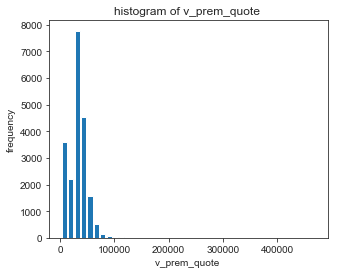

In [13]:
fig, ax=plt.subplots(1,1,figsize=(5,4))
plt.hist(insur_t.v_prem_quote ,bins=40,rwidth=0.8)
plt.title('histogram of v_prem_quote ')
plt.ylabel('frequency')
plt.xlabel('v_prem_quote ')

In [14]:
insur_t['v_prem_quote'].describe().round(3)

count     20460.000
mean      31689.197
std       18757.868
min        2630.000
25%       24731.750
50%       32533.500
75%       41294.250
max      472042.000
Name: v_prem_quote, dtype: float64

*** Analysis***

The variable v_prem_quote is not in normal distrubution, its better to use MinMaxScaler transofrmation. 

Text(0.5, 0, 'dl')

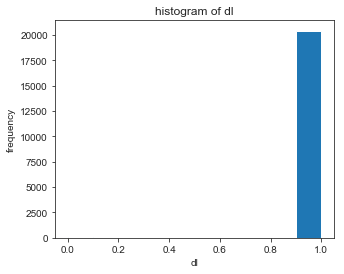

In [15]:
fig, ax=plt.subplots(1,1,figsize=(5,4))
plt.hist(insur_t.dl,bins=10,rwidth=1)
plt.title('histogram of dl')
plt.ylabel('frequency')
plt.xlabel('dl')

In [16]:
n_labels=insur_t['dl'].nunique()
labels=np.sort(insur_t['dl'].unique())
print(f'there are {n_labels} discrete labes in "dl";they are: {labels}')
print(f'thus,{n_labels - 1} flag vars are needed')

there are 2 discrete labes in "dl";they are: [0 1]
thus,1 flag vars are needed


***Analysis***

Most customers had default "1" for dl variable. 

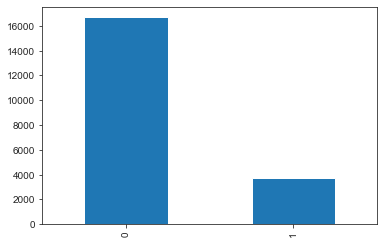

In [357]:
# analize the distribution of 0 vs 1 in out training data
buy_count = insur_t['buy'].value_counts()
fignew = plt.figure(figsize=(6,4))
buy_bar = buy_count.plot.bar()

***Analysis***

The data is imbalanced, there are more labels for 0 than for 1

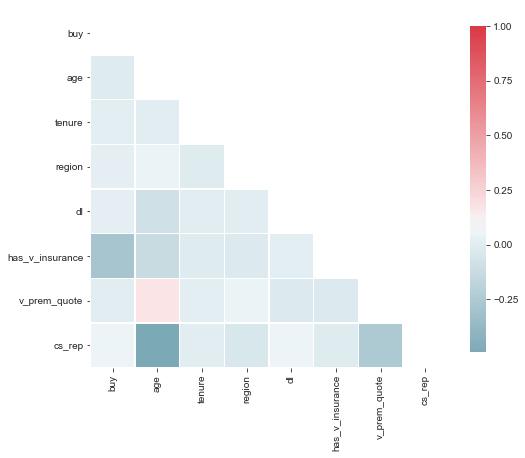

In [18]:
# get the correlation matrix for visualization and for a closer look later
corr = insur_t.drop(labels=[ 'id_new'], axis=1).corr()

# prepare tools for making a half-matrix correlation heatmap
mask = np.triu(np.ones_like(corr, bool))
f, ax = plt.subplots(1,1, figsize=(8, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# plot heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0.1, square=True, ax=ax, 
            linewidths=.5, cbar_kws={'shrink': .75})

In [19]:
corr

buy       age    tenure    region        dl  \
buy              1.000000 -0.003160  0.004972  0.016411  0.016950   
age             -0.003160  1.000000  0.002921  0.046449 -0.084692   
tenure           0.004972  0.002921  1.000000 -0.003793  0.001963   
region           0.016411  0.046449 -0.003793  1.000000  0.002517   
dl               0.016950 -0.084692  0.001963  0.002517  1.000000   
has_v_insurance -0.287762 -0.126007 -0.005641 -0.023856  0.008241   
v_prem_quote     0.000790  0.169832  0.004861  0.050187 -0.021075   
cs_rep           0.053184 -0.491662 -0.000362 -0.038545  0.051736   

                 has_v_insurance  v_prem_quote    cs_rep  
buy                    -0.287762      0.000790  0.053184  
age                    -0.126007      0.169832 -0.491662  
tenure                 -0.005641      0.004861 -0.000362  
region                 -0.023856      0.050187 -0.038545  
dl                      0.008241     -0.021075  0.051736  
has_v_insurance         1.000000     -0.023063 -0.012292  
v_prem_quote           -0.023063      1.000000 -0.253018  
cs_rep                 -0.012292     -0.253018  1.000000

***Analysis***

We found there is no strong correlation between the explanatory variables and the target variable.

### *Column transformer: streamline data preprocessing on train and test sets*

#### ont-hot-encoder

In [14]:
onehot_encoder = OneHotEncoder(drop='first')

# prepare list of column labels for one-hot-encoder
cols_onehot = ['gender', 'v_age', 'v_accident',  'cs_rep', 'dl', 'has_v_insurance']

#### min-max-norm

In [15]:
mmn_scaler = MinMaxScaler()

# prepare list of column labels for mmn-norm: those columns in X_train that are not in cols_onehot
cols_mmn_scale = X_train.drop(columns=cols_onehot).columns.tolist()

#### column transformer

In [16]:
transformer = make_column_transformer((onehot_encoder, cols_onehot), (mmn_scaler, cols_mmn_scale))

# use fit_transform() to fit train set X vars
X_train_processed = transformer.fit_transform(X_train)
#X_train_processed = X_train_processed.toarray()
X_train_processed = pd.DataFrame(X_train_processed)

# once fitted to train set, only use transform() on the test set X vars
X_test_processed = transformer.transform(X_test)
#X_test_processed = X_test_processed.toarray()
X_test_processed = pd.DataFrame(X_test_processed)


In [18]:
y_train_processed = pd.get_dummies(y_train)
y_test_processed = pd.get_dummies(y_test)

In [19]:
y_train_processed.head()

0  1
10452  1  0
15752  1  0
3482   1  0
16062  1  0
15363  1  0

In [36]:
X_train_processed.head()

0    1    2    3    4    5    6    7    8         9        10        11  \
0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.769231  0.366782  0.538462   
1  1.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  0.184615  0.128028  0.673077   
2  1.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  0.276923  0.930796  0.884615   
3  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.015385  0.913495  0.153846   
4  0.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  0.046154  0.124567  0.750000   

         12  
0  0.050957  
1  0.047304  
2  0.037123  
3  0.000000  
4  0.060275

In [16]:
display(X_train_processed.shape, y_train_processed.shape,X_test_processed.shape,y_test_processed.shape)

(12276, 13)

(12276, 2)

(8184, 13)

(8184, 2)

In [20]:
insur_t['buy'].value_counts()

0    16705
1     3755
Name: buy, dtype: int64

<a id='Model_development'></a>
## <font color = 'blue'>3.- Model Development and Evaluation</font>

In [21]:
X_tr = X_train_processed.squeeze().to_numpy()
X_ts = X_test_processed.squeeze().to_numpy()
y_tr = y_train_processed.squeeze().to_numpy()
y_ts = y_test_processed.squeeze().to_numpy()

X_tr.shape, y_tr.shape, X_ts.shape, y_ts.shape

((12276, 13), (12276, 2), (8184, 13), (8184, 2))

In [22]:
# Review the data
display(pd.DataFrame(X_tr).describe().round(2).loc[['min','max','mean','std']],
        pd.DataFrame(X_ts).describe().round(2).loc[['min','max','mean','std']])

0     1     2     3     4     5     6     7     8     9     10    11  \
min   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
max   1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00   
mean  0.55  0.25  0.07  0.68  0.17  0.26  0.13  1.00  0.28  0.35  0.50  0.51   
std   0.50  0.43  0.26  0.47  0.38  0.44  0.33  0.06  0.45  0.24  0.29  0.22   

        12  
min   0.00  
max   1.00  
mean  0.06  
std   0.04

0     1     2     3     4     5     6     7     8     9     10    11  \
min   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
max   1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  0.95  1.00  1.00   
mean  0.55  0.25  0.07  0.68  0.17  0.27  0.12  1.00  0.28  0.35  0.49  0.51   
std   0.50  0.43  0.25  0.47  0.38  0.44  0.33  0.05  0.45  0.24  0.29  0.22   

        12  
min   0.00  
max   0.95  
mean  0.06  
std   0.04

## <b> Building the model</b>

**The four model versions:**

1. basic MLP, SGD
1. MLP with L2 regularization, Adam
1. MLP with L2 regularization, Adam, 10% train set allotted to validation set
1. MLP with L2 regularization, Adam, 10% validation, improved activation functions

### define a model

In [23]:
model_notes_list = ['basic MLP, SGD', 
                    'MLP L2 regulariz, Adam', 
                    'MLP L2 regulariz, Adam, 10% validation set', 
                    'MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax']

Let's begin with a model with 7 hidden layers and 2 outputs. Two layers

In [24]:
# universal variables
m = X_tr.shape[1]; d = 11; t = 2
minibatch_size = 2**5

# <a id=10_epochs><font color = blue> Option1:10 epochs </font></a>


In [20]:
epochs=100

In [21]:
# classWeight = compute_class_weight(class_weight='balanced', classes= np.unique(y_train), y = y_train) 
# classWeight = dict(enumerate(classWeight))

mlp_list=[]
scores_list = []

tf.random.set_seed(random_state)

# track time
start = time()
sgd1 = keras.optimizers.Adam(learning_rate=0.00001)
#1
print(model_notes_list[0])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='sigmoid', name='hidden'),
                        keras.layers.Dense(t, activation='sigmoid', name='output')])
mlp.compile(optimizer= sgd1, loss='binary_crossentropy', metrics=['accuracy','AUC', 'Precision', 'Recall', 'FalsePositives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0) #  class_weight=classWeight
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

#2
# with Regularization and Adam
print('\n' + model_notes_list[1])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='sigmoid', name='hidden', kernel_regularizer='l2'),
                        keras.layers.Dense(t, activation='sigmoid', name='output', kernel_regularizer='l2')])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC', 'Precision', 'Recall','FalsePositives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0) # , class_weight=classWeight
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

#3
# MLP L2 regulariz, Adam, 10% validation set
print('\n' + model_notes_list[2])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='sigmoid', name='hidden', kernel_regularizer='l2'),
                        keras.layers.Dense(t, activation='sigmoid', name='output', kernel_regularizer='l2')])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC', 'Precision', 'Recall', 'FalsePositives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0, validation_split=0.1)
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

#4
# MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax
print('\n' + model_notes_list[3])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='relu', name='hidden', kernel_regularizer='l2'),
                        keras.layers.Dense(t, activation='softmax', name='output', kernel_regularizer='l2')])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall', 'FalsePositives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0, validation_split=0.1)
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

# track time
seconds = time() - start
mins, sec = divmod(seconds, 60)   # <-- divmod() returns a tuple of (quotient, remainder) after division
print('\nTook {:.0f} mins and {:.0f} sec'.format(mins, sec))

basic MLP, SGD

MLP L2 regulariz, Adam

MLP L2 regulariz, Adam, 10% validation set

MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax

Took 6 mins and 11 sec


In [23]:
test_cost_list = []
test_accuracy_list = []
test_auc_list = []
test_fp_list = []
test_f1score_list = []
test_precision_list = []
for model in mlp_list:
    cost, accuracy, auc, precision,recall ,false_positives = model.evaluate(X_ts, y_ts)
    test_cost_list.append(cost)
    test_accuracy_list.append(accuracy)
    test_auc_list.append(auc)
    test_precision_list.append(precision)
    test_fp_list.append(false_positives)
    test_f1score_list.append(2.*(precision*recall)/(precision+recall))

256/256 [==============================] - 1s 2ms/step - loss: 0.4283 - accuracy: 0.8177 - auc: 0.8922 - precision: 0.8177 - recall: 0.8177 - false_positives: 1492.0000


In [24]:
print('-'* 50)
for i in range(4):
    print(f'model: {model_notes_list[i]}')
    print(f'test set cost: {test_cost_list[i]:.4f}')
    print(f'test set accuracy: {test_accuracy_list[i]:.4f}')
    print(f'test set AUC: {test_auc_list[i]:.4f}')
    print(f'test set False Positives: {test_fp_list[i]:.2f}')
    print('-'* 50)

--------------------------------------------------
model: basic MLP, SGD
test set cost: 0.4581
test set accuracy: 0.8177
test set AUC: 0.8798
test set False Positives: 1492.00
--------------------------------------------------
model: MLP L2 regulariz, Adam
test set cost: 0.4750
test set accuracy: 0.8177
test set AUC: 0.8177
test set False Positives: 1492.00
--------------------------------------------------
model: MLP L2 regulariz, Adam, 10% validation set
test set cost: 0.4750
test set accuracy: 0.8177
test set AUC: 0.8177
test set False Positives: 1492.00
--------------------------------------------------
model: MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax
test set cost: 0.4283
test set accuracy: 0.8177
test set AUC: 0.8922
test set False Positives: 1492.00
--------------------------------------------------


# <a id=300_epochs><font color = blue> Option 2:300 epochs </font></a>


In [139]:
# universal variables
m = X_tr.shape[1]; d = 7; t = 2
epochs = 300
minibatch_size = 2**5

In [140]:
# classWeight = compute_class_weight(class_weight='balanced', classes= np.unique(y_train), y = y_train) 
# classWeight = dict(enumerate(classWeight))

mlp_list=[]
scores_list = []

tf.random.set_seed(random_state)

# track time
start = time()
sgd1 = keras.optimizers.Adam(learning_rate=0.00001)
#1
print(model_notes_list[0])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='sigmoid', name='hidden'),
                        keras.layers.Dense(t, activation='sigmoid', name='output')])
mlp.compile(optimizer= sgd1, loss='binary_crossentropy', metrics=['accuracy','AUC', 'Precision', 'Recall', 'FalsePositives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0) #  class_weight=classWeight
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

#2
# with Regularization and Adam
print('\n' + model_notes_list[1])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='sigmoid', name='hidden', kernel_regularizer='l2'),
                        keras.layers.Dense(t, activation='sigmoid', name='output', kernel_regularizer='l2')])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC', 'Precision', 'Recall','FalsePositives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0) # , class_weight=classWeight
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

#3
# MLP L2 regulariz, Adam, 10% validation set
print('\n' + model_notes_list[2])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='sigmoid', name='hidden', kernel_regularizer='l2'),
                        keras.layers.Dense(t, activation='sigmoid', name='output', kernel_regularizer='l2')])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC', 'Precision', 'Recall', 'FalsePositives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0, validation_split=0.1)
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

#4
# MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax
print('\n' + model_notes_list[3])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='relu', name='hidden', kernel_regularizer='l2'),
                        keras.layers.Dense(t, activation='softmax', name='output', kernel_regularizer='l2')])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall', 'FalsePositives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0, validation_split=0.1)
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

# track time
seconds = time() - start
mins, sec = divmod(seconds, 60)   # <-- divmod() returns a tuple of (quotient, remainder) after division
print('\nTook {:.0f} mins and {:.0f} sec'.format(mins, sec))

basic MLP, SGD

MLP L2 regulariz, Adam

MLP L2 regulariz, Adam, 10% validation set

MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax

Took 4 mins and 35 sec


[Index](#Index)

# <a id=10_neurons><font color = blue> Option 3: 10 epochs, 6 neurons </font></a>


In [181]:
# universal variables
d =6
epochs = 10

In [182]:
# classWeight = compute_class_weight(class_weight='balanced', classes= np.unique(y_train), y = y_train) 
# classWeight = dict(enumerate(classWeight))

mlp_list=[]
scores_list = []

tf.random.set_seed(random_state)

# track time
start = time()
sgd1 = keras.optimizers.Adam(learning_rate=0.00001)
#1
print(model_notes_list[0])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='sigmoid', name='hidden'),
                        keras.layers.Dense(t, activation='sigmoid', name='output')])
mlp.compile(optimizer= sgd1, loss='binary_crossentropy', metrics=['accuracy','AUC', 'Precision', 'Recall', 'FalsePositives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0) #  class_weight=classWeight
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

#2
# with Regularization and Adam
print('\n' + model_notes_list[1])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='sigmoid', name='hidden', kernel_regularizer='l2'),
                        keras.layers.Dense(t, activation='sigmoid', name='output', kernel_regularizer='l2')])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC', 'Precision', 'Recall','FalsePositives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0) # , class_weight=classWeight
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

#3
# MLP L2 regulariz, Adam, 10% validation set
print('\n' + model_notes_list[2])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='sigmoid', name='hidden', kernel_regularizer='l2'),
                        keras.layers.Dense(t, activation='sigmoid', name='output', kernel_regularizer='l2')])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC', 'Precision', 'Recall', 'FalsePositives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0, validation_split=0.1)
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

#4
# MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax
print('\n' + model_notes_list[3])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='relu', name='hidden', kernel_regularizer='l2'),
                        keras.layers.Dense(t, activation='softmax', name='output', kernel_regularizer='l2')])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall', 'FalsePositives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0, validation_split=0.1)
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

# track time
seconds = time() - start
mins, sec = divmod(seconds, 60)   # <-- divmod() returns a tuple of (quotient, remainder) after division
print('\nTook {:.0f} mins and {:.0f} sec'.format(mins, sec))

basic MLP, SGD

MLP L2 regulariz, Adam

MLP L2 regulariz, Adam, 10% validation set

MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax

Took 0 mins and 14 sec


In [183]:
test_cost_list = []
test_accuracy_list = []
test_auc_list = []
test_precision_list = []
test_fp_list = []
test_f1score_list = []
for model in mlp_list:
    cost, accuracy, auc, precision,recall ,false_positives = model.evaluate(X_ts, y_ts)
    test_cost_list.append(cost)
    test_accuracy_list.append(accuracy)
    test_auc_list.append(auc)
    test_precision_list.append(precision)
    test_fp_list.append(false_positives)
    test_f1score_list.append(2.*(precision*recall)/(precision+recall))

256/256 [==============================] - 0s 854us/step - loss: 0.4295 - accuracy: 0.8177 - auc: 0.8925 - precision: 0.8177 - recall: 0.8177 - false_positives: 1492.0000


In [184]:
print('-'* 50)
for i in range(4):
    print(f'model: {model_notes_list[i]}')
    print(f'test set cost: {test_cost_list[i]:.4f}')
    print(f'test set accuracy: {test_accuracy_list[i]:.4f}')
    print(f'test set AUC: {test_auc_list[i]:.4f}')
    print(f'test set Precision: {test_precision_list[i]:.4f}')
    print(f'test set False Positives: {test_fp_list[i]:.4f}')
    print('-'* 50)

--------------------------------------------------
model: basic MLP, SGD
test set cost: 0.5656
test set accuracy: 0.8177
test set AUC: 0.8591
test set Precision: 0.8157
test set False Positives: 1492.0000
--------------------------------------------------
model: MLP L2 regulariz, Adam
test set cost: 0.4783
test set accuracy: 0.8177
test set AUC: 0.8857
test set Precision: 0.8157
test set False Positives: 1492.0000
--------------------------------------------------
model: MLP L2 regulariz, Adam, 10% validation set
test set cost: 0.4798
test set accuracy: 0.8177
test set AUC: 0.8817
test set Precision: 0.8157
test set False Positives: 1492.0000
--------------------------------------------------
model: MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax
test set cost: 0.4295
test set accuracy: 0.8177
test set AUC: 0.8925
test set Precision: 0.8157
test set False Positives: 1492.0000
--------------------------------------------------


# <a id=weight><font color = blue> Option 4: 10 epochs, 6 neurons, updating weight </font></a>


In [210]:
# universal variables
d =6
epochs = 10

In [203]:
classWeight = compute_class_weight(class_weight='balanced', classes= np.unique(y_train), y = y_train) 
classWeight = dict(enumerate(classWeight))

mlp_list=[]
scores_list = []

tf.random.set_seed(random_state)

# track time
start = time()
sgd1 = keras.optimizers.Adam(learning_rate=0.00001)
#1
print(model_notes_list[0])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='sigmoid', name='hidden'),
                        keras.layers.Dense(t, activation='sigmoid', name='output')])
mlp.compile(optimizer= sgd1, loss='binary_crossentropy', metrics=['accuracy','AUC', 'Precision', 'Recall', 'FalsePositives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0,  class_weight=classWeight)
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

#2
# with Regularization and Adam
print('\n' + model_notes_list[1])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='sigmoid', name='hidden', kernel_regularizer='l2'),
                        keras.layers.Dense(t, activation='sigmoid', name='output', kernel_regularizer='l2')])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC', 'Precision', 'Recall','FalsePositives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0,  class_weight=classWeight)
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

#3
# MLP L2 regulariz, Adam, 10% validation set
print('\n' + model_notes_list[2])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='sigmoid', name='hidden', kernel_regularizer='l2'),
                        keras.layers.Dense(t, activation='sigmoid', name='output', kernel_regularizer='l2')])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC', 'Precision', 'Recall', 'FalsePositives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0, validation_split=0.1,  class_weight=classWeight)
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

#4
# MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax
print('\n' + model_notes_list[3])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='relu', name='hidden', kernel_regularizer='l2'),
                        keras.layers.Dense(t, activation='softmax', name='output', kernel_regularizer='l2')])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall', 'FalsePositives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0, validation_split=0.1,  class_weight=classWeight)
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

# track time
seconds = time() - start
mins, sec = divmod(seconds, 60)   # <-- divmod() returns a tuple of (quotient, remainder) after division
print('\nTook {:.0f} mins and {:.0f} sec'.format(mins, sec))

basic MLP, SGD

MLP L2 regulariz, Adam

MLP L2 regulariz, Adam, 10% validation set

MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax

Took 0 mins and 14 sec


In [204]:
test_cost_list = []
test_accuracy_list = []
test_auc_list = []
test_precision_list = []
test_fp_list = []
test_f1score_list = []
for model in mlp_list:
    cost, accuracy, auc, precision,recall ,false_positives = model.evaluate(X_ts, y_ts)
    test_cost_list.append(cost)
    test_accuracy_list.append(accuracy)
    test_auc_list.append(auc)
    test_precision_list.append(precision)
    test_fp_list.append(false_positives)
    test_f1score_list.append(2.*(precision*recall)/(precision+recall))

256/256 [==============================] - 0s 904us/step - loss: 0.6183 - accuracy: 0.5609 - auc: 0.6999 - precision: 0.5609 - recall: 0.5609 - false_positives: 3594.0000


In [205]:
print('-'* 50)
for i in range(4):
    print(f'model: {model_notes_list[i]}')
    print(f'test set cost: {test_cost_list[i]:.4f}')
    print(f'test set accuracy: {test_accuracy_list[i]:.4f}')
    print(f'test set AUC: {test_auc_list[i]:.4f}')
    print(f'test set Precision: {test_precision_list[i]:.4f}')
    print(f'test set False Positives: {test_fp_list[i]:.4f}')
    print('-'* 50)

--------------------------------------------------
model: basic MLP, SGD
test set cost: 0.6306
test set accuracy: 0.8173
test set AUC: 0.8493
test set Precision: 0.8157
test set False Positives: 1945.0000
--------------------------------------------------
model: MLP L2 regulariz, Adam
test set cost: 0.6925
test set accuracy: 0.5547
test set AUC: 0.6749
test set Precision: 0.8157
test set False Positives: 3669.0000
--------------------------------------------------
model: MLP L2 regulariz, Adam, 10% validation set
test set cost: 0.6817
test set accuracy: 0.5584
test set AUC: 0.7244
test set Precision: 0.8157
test set False Positives: 3614.0000
--------------------------------------------------
model: MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax
test set cost: 0.6183
test set accuracy: 0.5609
test set AUC: 0.6999
test set Precision: 0.8157
test set False Positives: 3594.0000
--------------------------------------------------


[Go to Index](#Index)

# <a id=batch><font color = blue> Option 5: 10 epochs, 6 neurons, increase the batches </font></a>


In [25]:
# universal variables
d =6
epochs = 20
minibatch_size = 2**12

In [26]:
# classWeight = compute_class_weight(class_weight='balanced', classes= np.unique(y_train), y = y_train) 
# classWeight = dict(enumerate(classWeight))

mlp_list=[]
scores_list = []

tf.random.set_seed(random_state)

# track time
start = time()
sgd1 = keras.optimizers.Adam(learning_rate=0.00001)
#1
print(model_notes_list[0])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='sigmoid', name='hidden'),
                        keras.layers.Dense(t, activation='sigmoid', name='output')])
mlp.compile(optimizer= sgd1, loss='binary_crossentropy', metrics=['accuracy','AUC', 'Precision', 'Recall', 'FalseNegatives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0) #  class_weight=classWeight
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

#2
# with Regularization and Adam
print('\n' + model_notes_list[1])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='sigmoid', name='hidden', kernel_regularizer='l2'),
                        keras.layers.Dense(t, activation='sigmoid', name='output', kernel_regularizer='l2')])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC', 'Precision', 'Recall','FalseNegatives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0) # , class_weight=classWeight
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

#3
# MLP L2 regulariz, Adam, 10% validation set
print('\n' + model_notes_list[2])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='sigmoid', name='hidden', kernel_regularizer='l2'),
                        keras.layers.Dense(t, activation='sigmoid', name='output', kernel_regularizer='l2')])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC', 'Precision', 'Recall', 'FalseNegatives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0, validation_split=0.1)
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

#4
# MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax
print('\n' + model_notes_list[3])
mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='relu', name='hidden', kernel_regularizer='l2'),
                        keras.layers.Dense(t, activation='softmax', name='output', kernel_regularizer='l2')])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall', 'FalseNegatives'])
history = mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0, validation_split=0.1)
scores = history.history
mlp_list.append(mlp); scores_list.append(scores)

# track time
seconds = time() - start
mins, sec = divmod(seconds, 60)   # <-- divmod() returns a tuple of (quotient, remainder) after division
print('\nTook {:.0f} mins and {:.0f} sec'.format(mins, sec))

basic MLP, SGD

MLP L2 regulariz, Adam

MLP L2 regulariz, Adam, 10% validation set

MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax

Took 0 mins and 20 sec


In [27]:
test_cost_list = []
test_accuracy_list = []
test_auc_list = []
test_precision_list = []
test_fp_list = []
test_f1score_list = []
for model in mlp_list:
    cost, accuracy, auc, precision,recall ,false_negatives = model.evaluate(X_ts, y_ts)
    test_cost_list.append(cost)
    test_accuracy_list.append(accuracy)
    test_auc_list.append(auc)
    test_precision_list.append(precision)
    test_fp_list.append(false_negatives)
    test_f1score_list.append(2.*(precision*recall)/(precision+recall))

256/256 [==============================] - 0s 2ms/step - loss: 0.6439 - accuracy: 0.8177 - auc: 0.7736 - precision: 0.8177 - recall: 0.8177 - false_negatives: 1492.0000


In [28]:
print('-'* 50)
for i in range(4):
    print(f'model: {model_notes_list[i]}')
    print(f'test set cost: {test_cost_list[i]:.4f}')
    print(f'test set accuracy: {test_accuracy_list[i]:.4f}')
    print(f'test set AUC: {test_auc_list[i]:.4f}')
    print(f'test set Precision: {test_precision_list[i]:.4f}')
    print(f'test set False Negatives: {test_fp_list[i]:.2f}')
    print(f'test set F1-score: {test_f1score_list[i]:.4f}')
    print('-'* 50)

--------------------------------------------------
model: basic MLP, SGD
test set cost: 0.6149
test set accuracy: 0.8177
test set AUC: 0.8527
test set Precision: 0.7819
test set False Negatives: 1292.00
test set F1-score: 0.8109
--------------------------------------------------
model: MLP L2 regulariz, Adam
test set cost: 0.6950
test set accuracy: 0.8177
test set AUC: 0.8252
test set Precision: 0.8187
test set False Negatives: 1680.00
test set F1-score: 0.8065
--------------------------------------------------
model: MLP L2 regulariz, Adam, 10% validation set
test set cost: 0.9848
test set accuracy: 0.1823
test set AUC: 0.1686
test set Precision: 0.1797
test set False Negatives: 6753.00
test set F1-score: 0.1773
--------------------------------------------------
model: MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax
test set cost: 0.6439
test set accuracy: 0.8177
test set AUC: 0.7736
test set Precision: 0.8177
test set False Negatives: 1492.00
test set F1-score: 0.8177
----

[Go to Index](#Index)

### plot cost curve of 4 models

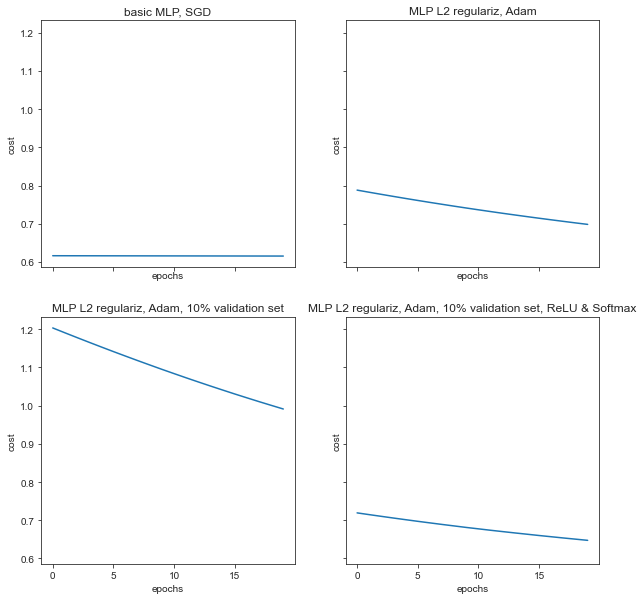

In [29]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(10, 10))
for i in range(2):
    for j in range(2):
        axx = ax[i, j]
        axx.plot(scores_list[i+j+(i==1)]['loss'])
        axx.set_title(model_notes_list[i+j+(i==1)])
        axx.set_xlabel('epochs')
        axx.set_ylabel('cost')

### plot test set accuracy of 4 models

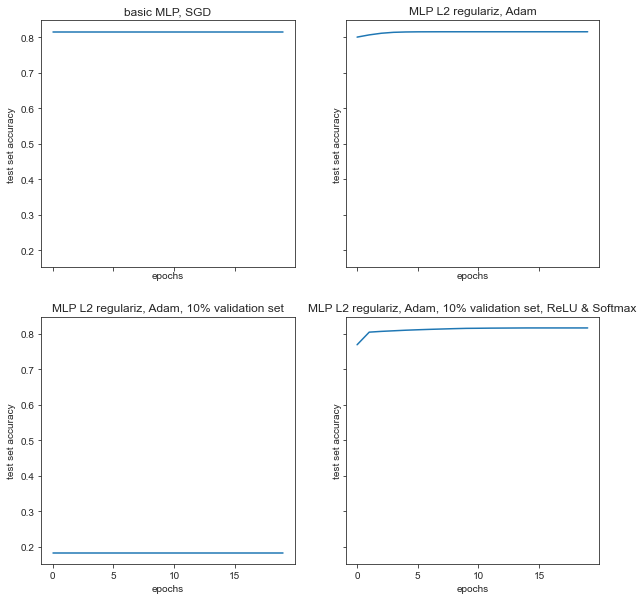

In [30]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(10, 10))
for i in range(2):
    for j in range(2):
        axx = ax[i, j]
        axx.plot(scores_list[i+j+(i==1)]['accuracy'])
        axx.set_title(model_notes_list[i+j+(i==1)])
        axx.set_xlabel('epochs')
        axx.set_ylabel('test set accuracy')

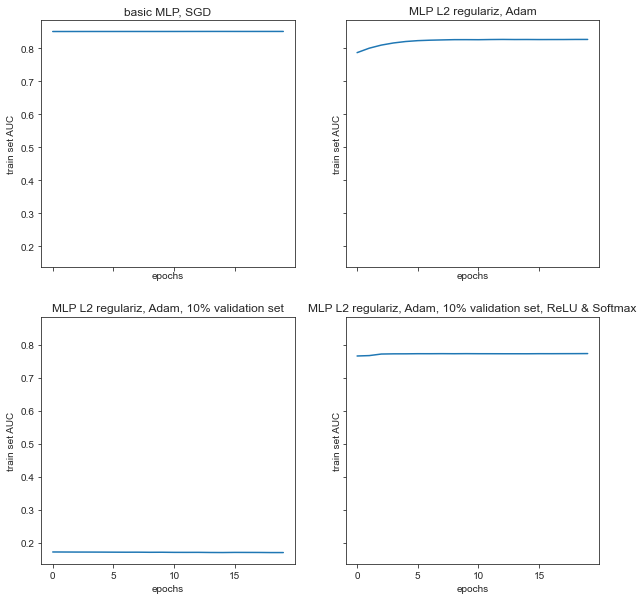

In [31]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(10, 10))
for i in range(2):
    for j in range(2):
        axx = ax[i, j]
        axx.plot(scores_list[i+j+(i==1)]['auc'])
        axx.set_title(model_notes_list[i+j+(i==1)])
        axx.set_xlabel('epochs')
        axx.set_ylabel('train set AUC')

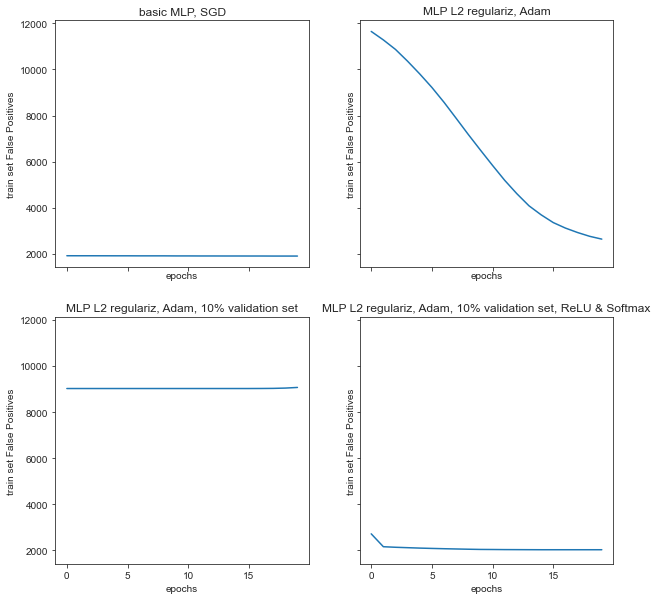

In [32]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(10, 10))
for i in range(2):
    for j in range(2):
        axx = ax[i, j]
        axx.plot(scores_list[i+j+(i==1)]['false_negatives'])
        axx.set_title(model_notes_list[i+j+(i==1)])
        axx.set_xlabel('epochs')
        axx.set_ylabel('train set False Positives')

[Go to Index](#Index)

### Finally, examine test and train set accuracy after sufficient training of all 4 models

In [33]:
test_cost_list = []
test_accuracy_list = []
test_auc_list = []
test_precision_list = []
test_fp_list = []
test_f1score_list = []
for model in mlp_list:
    cost, accuracy, auc, precision,recall ,false_negatives = model.evaluate(X_tr, y_tr)
    test_cost_list.append(cost)
    test_accuracy_list.append(accuracy)
    test_auc_list.append(auc)
    test_precision_list.append(precision)
    test_fp_list.append(false_negatives)
    test_f1score_list.append(2.*(precision*recall)/(precision+recall))
    

384/384 [==============================] - 1s 2ms/step - loss: 0.6459 - accuracy: 0.8157 - auc: 0.7717 - precision: 0.8157 - recall: 0.8157 - false_negatives: 2263.0000


In [354]:
test_cost_list = []
test_accuracy_list = []
test_auc_list = []
test_fp_list = []
test_f1score_list = []
for model in mlp_list:
    cost, accuracy, auc, precision,recall ,false_negatives = model.evaluate(X_ts, y_ts)
    test_cost_list.append(cost)
    test_accuracy_list.append(accuracy)
    test_auc_list.append(auc)
    test_precision_list.append(precision)
    test_fp_list.append(false_negatives)
    test_f1score_list.append(2.*(precision*recall)/(precision+recall))

256/256 [==============================] - 0s 927us/step - loss: 0.6439 - accuracy: 0.8177 - auc: 0.7736 - precision: 0.8177 - recall: 0.8177 - false_negatives: 1492.0000


In [34]:
print('-'* 50)
for i in range(4):
    print(f'model: {model_notes_list[i]}')
    print(f'test set cost: {test_cost_list[i]:.4f}')
    print(f'test set accuracy: {test_accuracy_list[i]:.4f}')
    print(f'test set AUC: {test_auc_list[i]:.4f}')
    print('-'* 50)

--------------------------------------------------
model: basic MLP, SGD
test set cost: 0.6154
test set accuracy: 0.8157
test set AUC: 0.8503
--------------------------------------------------
model: MLP L2 regulariz, Adam
test set cost: 0.6957
test set accuracy: 0.8157
test set AUC: 0.8259
--------------------------------------------------
model: MLP L2 regulariz, Adam, 10% validation set
test set cost: 0.9838
test set accuracy: 0.1843
test set AUC: 0.1704
--------------------------------------------------
model: MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax
test set cost: 0.6459
test set accuracy: 0.8157
test set AUC: 0.7717
--------------------------------------------------


[Go to Index](#Index)

<a id = analysis></a>
## Analysis:

1. We test our model with epoch = 10 and epochs = 300. The performance of the model with 10 epochs was slightly better: <br>

1. Increasing Neurons in hidden layers, with 10 epochs 

<u>hidden neurons = 10</u></p>
model: MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax<br>
test set cost: 0.4281<br>
test set accuracy: 0.8177<br>
test set AUC: 0.8923<br>
test set False Positives: 1492.0000<br>

<u>hidden neurons = 6, 10 epochs</u><br>
model: MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax<br>
test set cost: **0.4295**<br>
test set accuracy: 0.8177<br>
test set AUC: **0.8925**<br>
test set Precision: 0.8157<br>
test set False Positives: 1492.0000<br>

<u>hidden neurons = 7, 10 epochs</u><br>
model: MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax<br>
test set cost: **0.4301**<br>
test set accuracy: 0.8177<br>
test set AUC: **0.8925**<br>
test set Precision: 0.8157<br>
test set False Positives: 1492.0000<br>

<u>hidden neurons = 5, 10 epochs:</u><br>
model: MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax<br>
test set cost: 0.4295<br>
test set accuracy: 0.8177<br>
test set AUC: 0.8922<br>
test set False Positives: 1492.0000

1. Since the dataset is **imbalanced**, we modify the batch  size:
<u>MLP L2 regulariz, Adam, batch size: 2\*\*12</u><br>
test set cost: 0.7376<br>
test set accuracy: 0.8177<br>
test set AUC: 0.8246<br>
test set Precision: 0.8157<br>
test set False Positives: 984.00<br><br>
test set F1-score: 0.6257<br>

<u> MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax, batch size: 2\*\*12</u><br>
test set cost: 0.6776<br>
test set accuracy: 0.8172<br>
test set AUC: 0.7723<br>
test set Precision: 0.8157<br>
test set False Positives: 1496.00<br>
test set F1-score: **0.8172**<br>

<u>basic MLP, SGD, batch size: 2\*\*16</u><br>
test set cost: 0.6157<br>
test set accuracy: 0.8177<br>
test set AUC: 0.8524<br>
test set Precision: 0.8157<br>
test set False Positives: 1931.00<br>
test set F1-score: 0.8106<br>

<u>MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax, batch size: 2\*\*10</u><br>
test set cost: 0.6019<br>
test set accuracy: **0.8177** <br>
test set AUC: 0.7830<br>
test set Precision: 0.8157<br>
test set False Positives: 1492.00<br>
test set F1-score: **0.8177**<br>

<u>model: MLP L2 regulariz, Adam , batch size: 2\*\*10</u><br>
test set cost: 0.6326<br>
test set accuracy: **0.8177**<br>
test set AUC: 0.8255
test set Precision: 0.8157<br>
test set False Positives: 1492.00<br>
test set F1-score: **0.8177**<br>

<u>model: basic MLP, SGD , batch size: 2\*\*12</u><br>
test set cost: 0.6154<br>
test set accuracy: 0.8177<br>
test set AUC: **0.8526**
test set Precision: 0.8157<br>
test set False Positives: 1928.00<br>
test set F1-score: 0.8107<br>


<u>model: basic MLP, SGD, batch size: 2\*\*12, epochs: 20</u><br>
test set cost: 0.6149<br>
test set accuracy: 0.8177<br>
test set AUC: <font color = 'blue'>**0.8527**</font><br>
test set Precision: 0.7856<br>
test set False Positives: 1922.00<br><br>
test set F1-score: 0.8109<br>

<u>model: MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax, batch size: 2\*\*12, epochs: 200</u><br>
test set cost: 0.4430
test set accuracy: 0.8177
test set AUC: 0.8924
test set Precision: 0.8157
test set False Positives: 1492.00
test set F1-score: 0.8177

model: MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax
test set cost: 0.4283
test set accuracy: 0.8177
test set AUC: 0.8922
test set False Positives: 1492.00

model: MLP L2 regulariz, Adam, 10% validation set, ReLU & Softmax
test set cost: 0.4903
test set accuracy: 0.8177
test set AUC: 0.8788
test set Precision: 0.8157
test set False Positives: 1492.00
test set F1-score: 0.8177


[Go to Index](#Index)

<a id='Predict'></a>
## <font color = 'blue'>4.- Predict</font>

## <b> The final model</b>

In [35]:
epochs=20
d=6
minibatch_size=2**12
sgd1 = keras.optimizers.Adam(learning_rate=0.00001)
#1
print(model_notes_list[0])
f_mlp = keras.Sequential([keras.layers.Dense(d, input_shape=(m,), activation='sigmoid', name='hidden'),
                        keras.layers.Dense(t, activation='sigmoid', name='output')])
f_mlp.compile(optimizer= sgd1, loss='binary_crossentropy', metrics=['accuracy','AUC', 'Precision', 'Recall', 'FalsePositives'])
f_mlp.fit(x=X_tr, y=y_tr, batch_size=minibatch_size, epochs=epochs, verbose=0) #  class_weight=classWeight
#scores = history.history
#mlp_list.append(mlp); scores_list.append(scores)

basic MLP, SGD


[Go to Index](#Index)

## Prepare the Score data

### Compairing columns

In [270]:
print('Is there any difference in the input column labels between the two dataframes?', 
      (insur_s.columns != insur_t.drop('buy', axis=1).columns).any())

Is there any difference in the input column labels between the two dataframes? False


In [36]:
df_score = insur_s.drop(columns=['id_new'])

In [37]:
print(f'These columns have at least 1 missing value: {df_score.columns[df_score.isnull().sum().astype(bool)].tolist()}')

These columns have at least 1 missing value: []


#### column transformer

In [38]:
# transformer = make_column_transformer((onehot_encoder, cols_onehot), (mmn_scaler, cols_mmn_scale))

X_score = transformer.transform(df_score)
X_score= pd.DataFrame(X_score)


In [39]:
X_s = X_score.squeeze().to_numpy()
X_s.shape

(2000, 13)

In [45]:
y=f_mlp.predict_classes(X_score, batch_size=2**10)
y_probability = f_mlp.predict(X_score)

In [60]:
# show the inputs and predicted outputs
for i in range(len(X_s)):
	print("X=%s, Predicted=%s, Probability=%s" % (X_s[i], y[i], y_probability[i,1]))

X=[1.         0.         0.         1.         0.         0.
 1.         1.         0.         0.4        0.39446367 0.11538462
 0.05026714], Predicted=0, Probability=0.50762796
X=[0.         1.         0.         1.         0.         1.
 0.         1.         0.         0.07692308 0.95155709 0.88461538
 0.08933304], Predicted=1, Probability=0.60280746
X=[1.         0.         0.         0.         0.         0.
 0.         1.         1.         0.33846154 0.29411765 0.53846154
 0.06000273], Predicted=0, Probability=0.5635471
X=[0.         0.         0.         1.         0.         0.
 1.         1.         0.         0.29230769 0.75778547 0.5
 0.0703838 ], Predicted=1, Probability=0.55723774
X=[1.         0.         0.         1.         0.         0.
 0.         1.         0.         0.33846154 0.35986159 0.53846154
 0.06265072], Predicted=1, Probability=0.54757977
X=[0.         0.         0.         1.         0.         0.
 0.         1.         0.         0.43076923 0.06574394 0

 0.05444684], Predicted=1, Probability=0.6029595
X=[1.         0.         0.         0.         0.         0.
 0.         1.         0.         0.67692308 0.183391   0.53846154
 0.07993405], Predicted=0, Probability=0.5600816
X=[0.         0.         1.         1.         0.         0.
 0.         1.         0.         0.36923077 0.21799308 0.53846154
 0.13951923], Predicted=1, Probability=0.61437535
X=[0.         1.         0.         0.         1.         0.
 0.         1.         1.         0.04615385 0.58823529 0.88461538
 0.05778506], Predicted=1, Probability=0.5886789
X=[0.         0.         1.         1.         0.         0.
 0.         1.         0.         0.81538462 0.22145329 0.19230769
 0.06014972], Predicted=1, Probability=0.60416156
X=[1.         0.         0.         1.         0.         1.
 0.         1.         0.         0.38461538 0.15224913 0.78846154
 0.06018807], Predicted=1, Probability=0.5628159
X=[0.         0.         0.         1.         0.         0.
 0.

 0.0691823 ], Predicted=1, Probability=0.58826756
X=[1.         0.         0.         1.         0.         0.
 0.         1.         0.         0.38461538 0.66782007 0.53846154
 0.09629494], Predicted=1, Probability=0.54898244
X=[1.         0.         0.         0.         0.         0.
 0.         1.         1.         0.46153846 0.2283737  0.53846154
 0.06427403], Predicted=0, Probability=0.55916107
X=[0.         0.         0.         0.         0.         1.
 0.         1.         1.         0.32307692 0.02422145 0.40384615
 0.05795122], Predicted=1, Probability=0.63097996
X=[0.         0.         0.         1.         0.         0.
 0.         1.         0.         0.49230769 0.40138408 0.53846154
 0.08427991], Predicted=1, Probability=0.58865094
X=[1.         0.         0.         1.         0.         0.
 1.         1.         0.         0.36923077 0.04844291 0.28846154
 0.04608958], Predicted=0, Probability=0.50489706
X=[1.         1.         0.         1.         0.         1.

X=[0.         0.         1.         1.         0.         0.
 0.         1.         0.         0.29230769 0.97923875 0.53846154
 0.0701729 ], Predicted=1, Probability=0.62488675
X=[0.         1.         0.         1.         0.         1.
 0.         1.         0.         0.15384615 0.69204152 0.34615385
 0.15139792], Predicted=1, Probability=0.59978396
X=[1.         1.         0.         1.         1.         0.
 0.         1.         0.         0.06153846 0.61937716 0.69230769
 0.06103167], Predicted=1, Probability=0.537177
X=[0.         0.         0.         1.         0.         0.
 0.         1.         0.         0.6        0.87197232 0.53846154
 0.0575699 ], Predicted=1, Probability=0.590166
X=[0.         0.         1.         1.         0.         1.
 0.         1.         0.         0.90769231 0.73010381 0.53846154
 0.        ], Predicted=1, Probability=0.62323695
X=[0.         0.         0.         1.         0.         0.
 0.         1.         0.         0.69230769 0.937716

X=[1.         0.         0.         1.         0.         0.
 0.         1.         0.         0.89230769 0.97923875 0.53846154
 0.0844269 ], Predicted=0, Probability=0.5359969
X=[1.         0.         0.         1.         0.         0.
 1.         1.         0.         0.55384615 0.65743945 0.11538462
 0.05365223], Predicted=0, Probability=0.5059037
X=[0.         1.         0.         0.         1.         0.
 0.         1.         1.         0.06153846 0.71972318 0.28846154
 0.07712415], Predicted=1, Probability=0.59317034
X=[0.         0.         0.         1.         0.         0.
 0.         1.         0.         0.44615385 0.6366782  0.53846154
 0.04484334], Predicted=1, Probability=0.59287584
X=[1.         0.         0.         1.         0.         0.
 0.         1.         0.         0.27692308 0.60899654 0.53846154
 0.06324508], Predicted=1, Probability=0.55229086
X=[1.         1.         0.         0.         0.         0.
 1.         1.         1.         0.12307692 0.7923

 0.07654257], Predicted=1, Probability=0.5532154
X=[0.         0.         1.         1.         0.         0.
 0.         1.         0.         0.30769231 0.89619377 0.53846154
 0.10134594], Predicted=1, Probability=0.6232567
X=[0.         1.         0.         0.         1.         0.
 0.         1.         1.         0.07692308 0.90657439 0.15384615
 0.07888806], Predicted=1, Probability=0.59506696
X=[0.         0.         0.         1.         0.         0.
 1.         1.         0.         0.12307692 0.21799308 0.88461538
 0.04727404], Predicted=1, Probability=0.5562238
X=[1.         0.         0.         1.         0.         1.
 0.         1.         1.         0.23076923 0.24913495 0.53846154
 0.02978194], Predicted=0, Probability=0.56271404
X=[0.         1.         0.         1.         0.         1.
 0.         1.         0.         0.2        0.69204152 0.40384615
 0.07423117], Predicted=1, Probability=0.59876376
X=[1.         0.         0.         0.         0.         0.
 0

 0.        ], Predicted=1, Probability=0.55287343
X=[0.         0.         0.         1.         0.         1.
 0.         1.         0.         0.21538462 0.80622837 0.82692308
 0.07094834], Predicted=1, Probability=0.6197523
X=[0.         0.         0.         0.         0.         0.
 0.         1.         1.         0.53846154 0.69204152 0.53846154
 0.06307679], Predicted=1, Probability=0.6056123
X=[1.         0.         0.         0.         0.         0.
 0.         1.         1.         0.36923077 0.89273356 0.53846154
 0.07535172], Predicted=0, Probability=0.56582814
X=[0.         0.         0.         1.         0.         1.
 0.         1.         0.         0.32307692 0.51557093 0.21153846
 0.04742742], Predicted=1, Probability=0.618519
X=[0.         0.         0.         1.         0.         1.
 0.         1.         0.         0.15384615 0.43944637 0.13461538
 0.07286563], Predicted=1, Probability=0.6237106
X=[1.         0.         0.         1.         0.         0.
 0. 

 0.07459758], Predicted=0, Probability=0.56374437
X=[0.         0.         0.         1.         0.         1.
 0.         1.         0.         0.56923077 0.40484429 0.53846154
 0.07806788], Predicted=1, Probability=0.6072018
X=[1.         0.         0.         1.         0.         0.
 0.         1.         0.         0.29230769 0.59515571 0.53846154
 0.06041814], Predicted=1, Probability=0.5516647
X=[1.         1.         0.         0.         1.         0.
 0.         1.         1.         0.04615385 0.20069204 0.53846154
 0.08891762], Predicted=0, Probability=0.5434732
X=[1.         1.         0.         0.         1.         0.
 0.         1.         0.         0.04615385 0.13148789 0.90384615
 0.05087002], Predicted=0, Probability=0.55066264
X=[1.         0.         0.         0.         0.         0.
 0.         1.         1.         0.72307692 0.10034602 0.92307692
 0.        ], Predicted=0, Probability=0.5482022
X=[1.         0.         0.         0.         0.         0.
 0.

 0.08619933], Predicted=1, Probability=0.61204344
X=[1.         0.         0.         0.         0.         1.
 0.         1.         1.         0.27692308 0.85121107 0.86538462
 0.04450035], Predicted=1, Probability=0.5873905
X=[0.         0.         0.         1.         0.         1.
 0.         1.         0.         0.29230769 0.26297578 0.98076923
 0.08089056], Predicted=1, Probability=0.61183524
X=[1.         1.         0.         1.         0.         1.
 0.         1.         1.         0.16923077 0.19723183 0.21153846
 0.05616388], Predicted=0, Probability=0.54352355
X=[0.         0.         0.         1.         0.         0.
 0.         1.         0.         0.52307692 0.82698962 0.53846154
 0.06468092], Predicted=1, Probability=0.59213483
X=[1.         0.         0.         1.         0.         0.
 0.         1.         0.         0.29230769 0.17647059 0.53846154
 0.06868167], Predicted=0, Probability=0.54712844
X=[0.         0.         0.         1.         0.         0.


In [76]:
predictedS = pd.DataFrame(list(zip(insur_s['id_new'], y_probability[:,1], y)), 
                          columns=['id_new','Probability', 'Classification'])

In [77]:
predictedS.to_csv("Scored_Buy_final.csv", index=False)

[Index](#Index)

<a id='Summary'></a>
## <font color = 'blue'>4.- Summary</font>

1. The `Accuracy`remains the same for all models, that's why we decided to analyze the AUC, cost and F1-score.

1. For this case we consider that a `False Negative` is worst than a False Positive. A False Negative is when the model predict that the customer will not buy the insurance so the sales representative does not call him, but in fact, the client will buy the insurance.<br>
If the model incorrectly classify a client as a not buyer and he is a buyer, the company will lose the opportunity to sell the insurance.

1. We noticed that the data is imbalanced, then we modified the batch size so the training model can take some values with 0 and 1. We suspect that in our previous models most of the samples have 0 values for all rows, that's why it predicted 0s for all cases. With a wider batch size, our model is now including samples with labels = 1 and it is learning properly.

1. Finally, we choose model: <u>model: basic MLP, SGD, batch size: 2\*\*12, epochs: 20</u><br>
test set cost: 0.6149<br>
test set accuracy: 0.8177<br>
test set AUC: <font color = 'blue'>**0.8527**</font><br>
test set Precision: 0.7856<br>
test set False Positives: 1922.00<br>
test set F1-score: 0.8109<br>